# The local unitary cluster Jastrow (LUCJ) ansatz

This page explains the local unitary cluster Jastrow (LUCJ) ansatz, which was originally introduced in [this paper](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k). For a guide on simulating the LUCJ ansatz using ffsim, see [How to simulate the local unitary cluster Jastrow (LUCJ) ansatz](../how-to-guides/simulate-lucj.ipynb).

## The general unitary cluster Jastrow (UCJ) ansatz

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{k = 0}^{L - 1} \mathcal{U}_k e^{i \mathcal{J}_k} \mathcal{U}_k^\dagger \lvert \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken as the Hartree-Fock state, each $\mathcal{U}_k$ is an [orbital rotation](orbital-rotation.ipynb), and each $\mathcal{J}_k$ is a diagonal Coulomb operator of the form

$$
    \mathcal{J} = \frac12\sum_{ij,\sigma \tau} \mathbf{J}^{\sigma \tau}_{ij} n_{i,\sigma} n_{j,\tau}.
$$

In ffsim, the UCJ ansatz is represented using classes that store the diagonal Coulomb matrices and orbital rotations as Numpy arrays. To facilitate variational optimization of the ansatzes, these classes implement methods for conversion to and from a vector of real-valued parameters. The parameter vector stores the entries of the UCJ matrices in a non-redundant way (for the orbital rotations, the parameter vector actually stores the entries of their logarithm).

### Spin-balanced and spin-unbalanced ansatzes

ffsim implements two variants of the UCJ ansatz, a "spin-balanced" ansatz, which is appropriate to apply to a closed-shell reference state, and a "spin-unbalanced" ansatz, which is appropriate to apply to an open-shell initial reference state.

In the spin-balanced ansatz, $\mathbf{J}^{\alpha\alpha} = \mathbf{J}^{\beta\beta}$ and $\mathbf{J}^{\alpha\beta} = \mathbf{J}^{\beta\alpha}$. As a result, each diagonal Coulomb operator is described by 2 matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$, and both of these matrices are symmetric. The spin-balanced UCJ ansatz is represented by the [UCJOpSpinBalanced](../api/ffsim.rst#ffsim.UCJOpSpinBalanced) class.

In the spin-unbalanced ansatz, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are allowed to differ, and $\mathbf{J}^{\alpha\beta}$ is no longer required to be symmetric. Since $\mathbf{J}^{\alpha\beta}_{ij} = \mathbf{J}^{\beta\alpha}_{ji}$, we don't need to store $\mathbf{J}^{\beta\alpha}$ separately. Therefore, each diagonal Coulomb operator is described by 3 matrices, $\mathbf{J}^{\alpha\alpha}$, $\mathbf{J}^{\alpha\beta}$, and $\mathbf{J}^{\beta\beta}$, and of these matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are symmetric. The spin-unbalanced UCJ ansatz is represented by the [UCJOpSpinUnbalanced](../api/ffsim.rst#ffsim.UCJOpSpinUnbalanced) class.

## The local UCJ (LUCJ) ansatz

Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$ matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. The constraints are specified by a list of indices indicating which matrix entries in the upper triangle are allowed to be nonzero (since the matrices are symmetric, only the upper triangle needs to be specified). These indices can be interpreted as pairs of orbitals that are allowed to interact.

As an example, consider a square lattice qubit topology. We can place the $\alpha$ and $\beta$ orbitals in parallel lines on the lattice, with connections between these lines forming "rungs" of a ladder shape, like this:

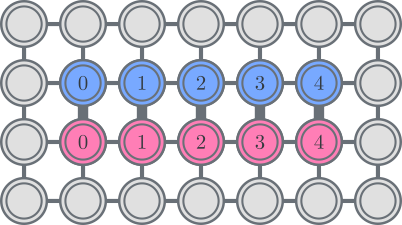

With this setup, orbitals with the same spin are connected with a line topology, while orbitals with different spins are connected when they share the same spatial orbital. This yields the following index constraints on the $\mathbf{J}$ matrices:

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

In other words, if the $\mathbf{J}$ matrices are nonzero only at the specified indices in the upper triangle, then the $e^{i \mathcal{J}_k}$ term can be implemented on a square topology without using any swap gates, in constant depth. Of course, imposing such constraints on the ansatz makes it less expressive, so more ansatz repetitions may be required.



## Parameter initialization from CCSD

The parameters of the (L)UCJ ansatz can be initialized from the results of a coupled cluster, singles and doubles (CCSD) calculation. This section explains how this initialization works, and how it's implemented in ffsim.

### CCSD and UCCSD

CCSD is a computational method that approximates the ground state wavefunction with an exponential ansatz,
$$
\lvert \Psi_\text{CCSD} \rangle = e^{T}\lvert \Phi_0 \rangle,
$$
where
$$
T = T_1 + T_2
$$
with
$$
T_1 = \sum_{ia} t_{ia} c^\dagger_i c_a, \quad
T_2 = \sum_{ijab} t_{ijab} c^\dagger_i c^\dagger_j c_a c_b.
$$
The ansatz is parameterized by the numbers $t_{ia}$ and $t_{ijab}$, called $t$-amplitudes (separately, $t_1$- and $t_2$-amplitudes), which can be efficiently solved for on a classical computer.

Unitary CCSD (UCCSD) is a variant of CCSD that uses a similar exponential ansatz, but with an operator that is guaranteed to be unitary,
$$
\lvert \Psi_\text{UCCSD} \rangle = e^{T - T^\dagger}\lvert \Phi_0 \rangle.
$$
While UCCSD is challenging to implement on a classical computer, it can be implemented efficiently on a quantum computer. Like CCSD, UCCSD is also parameterized by the $t$-amplitudes $t_{ia}$ and $t_{ijab}$. If the same $t$-amplitudes from CCSD are plugged into UCCSD, and $\lvert \Phi_0 \rangle$ is the Hartree-Fock state, then because $T^\dagger \lvert \Phi_0 \rangle = 0$, the resulting ansatz states match up to first order in $T$ in the Taylor series of the exponential operators. Therefore, the $t$-amplitudes obtained from a CCSD calculation may serve as a reasonable initial guess for UCCSD.

### From UCCSD to (L)UCJ

The UCJ ansatz can be related to the UCCSD ansatz via a double-factorized representation of the $T_2$ operator. We can focus on the $T_2$ operator because the $T_1$ operator can be separated by invoking a Trotter approximation:
$$
e^{T - T^\dagger} = e^{T_1 - T_1^\dagger + T_2 - T_2^\dagger} \approx e^{T_1 - T_1^\dagger} e^{T_2 - T_2^\dagger}.
$$
Because $T_1$ contains only quadratic terms, $e^{T_1 - T_1^\dagger}$ is an [orbital rotation](orbital-rotation.ipynb), so it can be implemented efficiently on a quantum computer. To approximate $e^{T_2 - T_2^\dagger}$, we represent $T_2 - T_2^\dagger$ in a double-factorized form,
$$
T_2 - T_2^\dagger = i\sum_{k=0}^{L - 1} \mathcal{U}_k \mathcal{J}_k \mathcal{U}_k^\dagger.
$$
As with the [double-factorized representation of the molecular Hamiltonian](double-factorized.ipynb), here the $\mathcal{U}_k$ are orbital rotations and the $\mathcal{J}_k$ are diagonal Coulomb operators. Finally, to obtain an operator in UCJ form, we invoke a Trotter approximation:
$$
e^{T_2 - T_2^\dagger} = e^{i\sum_{k=0}^{L - 1} \mathcal{U}_k \mathcal{J}_k \mathcal{U}_k^\dagger} \approx \prod_{k=0}^{L - 1} \mathcal{U}_k e^{i\mathcal{J}_k} \mathcal{U}_k^\dagger.
$$
Thus, the $t$-amplitudes obtained from a CCSD calculation may also yield an initial guess for UCJ via double factorization of the $t_2$-amplitudes. If a final orbital rotation is included in the ansatz, it can be initialized from the $t_1$-amplitudes. An LUCJ ansatz can be initialized by first constructing the UCJ ansatz, and then dropping the interactions that are unavailable due to the locality constraints.

### Truncation error and the compressed double factorization

Initializing the UCJ ansatz from CCSD $t$-amplitudes can often yield a reasonable approximation to CCSD. However, discarding interactions to obtain an LUCJ ansatz can severely degrade the quality of the approximation. Additionally, truncating the ansatz to a smaller number of repetitions, compared to the full number of terms in the double factorization of the $t_2$-amplitudes, also degrades the quality of the approximation. This degradation can be mitigated by performing an optimization that adjusts the orbital rotations and diagonal Coulomb operators from the truncated double factorization so that the $t_2$-amplitudes that would be recovered from them better match the original $t_2$-amplitudes. This procedure is referred to as a "compressed" double factorization because it compresses the information from a full double factorization into a smaller number of terms (or interactions).

The double factorization of the $t_2$-amplitudes returns tensors $U^{(k)}_{ij}$ and $Z^{(k)}_{ij}$ such that
$$
t_{ijab} = i \sum_{k=0}^{L - 1} \sum_{pq}
    Z^{(k)}_{pq}
    U^{(k)}_{ap} U^{(k)*}_{ip} U^{(k)}_{bq} U^{(k)*}_{jq}.
$$
Here, each $Z^{(k)}$ is a real symmetric matrix representing a diagonal Coulomb operator, each $U^{(k)}$ is a unitary matrix representing an orbital rotation, $i$ and $j$ run over occupied orbitals, and $a$ and $b$ run over virtual orbitals. If the number of terms in the sum is truncated, or if some diagonal Coulomb interactions are dropped (by zeroing out the corresponding entries of the $Z^{(k)}$ matrices), then the equality no longer holds. However, given any two tensors $\bar{U}^{(k)}_{ij}$ and $\bar{Z}^{(k)}_{ij}$, we can plug them into the expression to obtain some $t_2$-amplitudes $\bar{t}_{ijab}$. The compressed double factorization attempts to find tensors that minimize the least-squares objective function
$$
\frac12 \sum_{ijab} \lvert \bar{t}_{ijab} - t_{ijab} \rvert ^2.
$$

The LUCJ ansatz specifies connectivity constraints described by index sets $S_{\alpha \alpha}$ and $S_{\alpha \beta}$. For example, for square lattice connectivity, the sets are
$$
\begin{align*}
S_{\alpha \alpha} &= \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
S_{\alpha \beta} &= \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$
The index sets specify which diagonal Coulomb interactions are permitted, corresponding to which entries of the $Z^{(k)}$ matrices are allowed to be nonzero. Because the expression for the $t_2$-amplitudes does not distinguish separate $Z^{(k)}$ matrices for same-spin and opposite-spin interactions, we use a heuristic in which, during the optimization, entries of the $Z^{(k)}$ matrices with indices that appear in either set are allowed to be nonzero. As a result, some interactions still need to be discarded when constructing the LUCJ ansatz, but fewer than if no constraints were considered at all.

### Numerical study of parameter initialization

This section demonstrates the ideas of the preceding discussion with numerical simulation. We study a nitrogen molecule at varying bond lengths with an active space of 10 electrons in 8 orbitals, with the STO-6G basis set. First, we use PySCF to run CCSD, as well as configuration interaction, singles and doubles (CISD), a less costly method, for comparison. We also run full configuration interaction (FCI) to obtain the exact ground state energy.

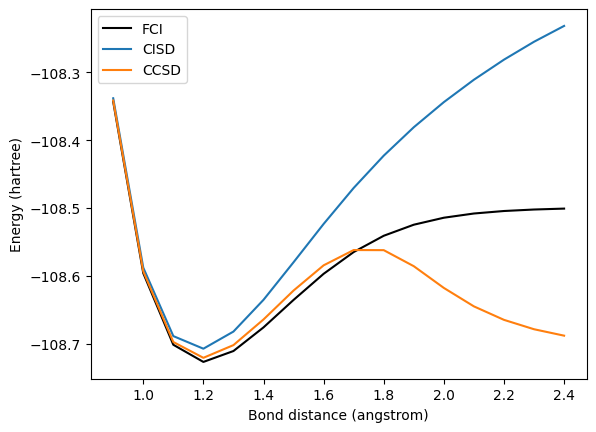

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyscf.cc
import pyscf.ci
import pyscf.mcscf

import ffsim

# Set bond distance range for N2 molecule
start = 0.9
stop = 2.4
step = 0.1
bond_distance_range = np.linspace(start, stop, num=round((stop - start) / step) + 1)

mol_datas = []
for bond_distance in bond_distance_range:
    # Build molecule
    mol = pyscf.gto.Mole()
    mol.build(
        atom=[("N", (-0.5 * bond_distance, 0, 0)), ("N", (0.5 * bond_distance, 0, 0))],
        basis="sto-6g",
        symmetry="Dooh",
        verbose=0,
    )
    # Run Hartree-Fock
    scf = pyscf.scf.RHF(mol)
    scf.kernel()
    # Get molecular integrals
    active_space = list(range(2, mol.nao_nr()))
    norb = len(active_space)
    nelectron_cas = int(sum(scf.mo_occ[active_space]))
    n_alpha = (nelectron_cas + mol.spin) // 2
    n_beta = (nelectron_cas - mol.spin) // 2
    nelec = (n_alpha, n_beta)
    cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
    mo_coeff = cas.sort_mo(active_space, base=0)
    h1e_cas, ecore = cas.get_h1eff(mo_coeff=mo_coeff)
    h2e_cas = cas.get_h2eff(mo_coeff=mo_coeff)
    # Run CISD
    cisd = pyscf.ci.RCISD(
        scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
    )
    cisd.kernel()
    # Run CCSD
    ccsd = pyscf.cc.RCCSD(
        scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
    )
    ccsd.kernel(
        # Initialize with t-amplitudes from previous iteration to improve convergence
        t1=mol_datas[-1].ccsd_t1 if mol_datas else None,
        t2=mol_datas[-1].ccsd_t2 if mol_datas else None,
    )
    # Run FCI
    cas.fix_spin_(ss=0)
    cas.kernel(mo_coeff=mo_coeff)
    # Store data
    mol_data = ffsim.MolecularData(
        norb=norb,
        nelec=nelec,
        core_energy=ecore,
        one_body_integrals=h1e_cas,
        two_body_integrals=h2e_cas,
        cisd_energy=cisd.e_tot,
        ccsd_energy=ccsd.e_tot,
        ccsd_t1=ccsd.t1,
        ccsd_t2=ccsd.t2,
        fci_energy=cas.e_tot,
    )
    mol_datas.append(mol_data)

# Plot FCI, CISD, and CCSD energies
fig, ax = plt.subplots()
ax.plot(
    bond_distance_range,
    [mol_data.fci_energy for mol_data in mol_datas],
    "-",
    label="FCI",
    color="black",
)
ax.plot(
    bond_distance_range,
    [mol_data.cisd_energy for mol_data in mol_datas],
    "-",
    label="CISD",
)
ax.plot(
    bond_distance_range,
    [mol_data.ccsd_energy for mol_data in mol_datas],
    "-",
    label="CCSD",
)
ax.set_xlabel("Bond distance (angstrom)")
ax.set_ylabel("Energy (hartree)")
ax.legend()

Near the equilibrium bond length, which is around 1.2 angstroms at this level of theory, CCSD approximates the ground state energy fairly well. However, at stretched bond lengths, CCSD is unable to capture the static correlation of the electrons, and it begins to undershoot the exact energy (the CCSD energy is not variational, so it can return values below the ground state energy).

In the next code cell, we use the $t$-amplitudes from CCSD to initialize UCCSD and UCJ ansatzes. For each bond length, we apply the ansatz operator to the Hartree-Fock state, and compute the energy (expectation value of the Hamiltonian) of the resulting state. Instead of plotting the energy directly, we'll plot the error, that is, the difference from the exact energy.

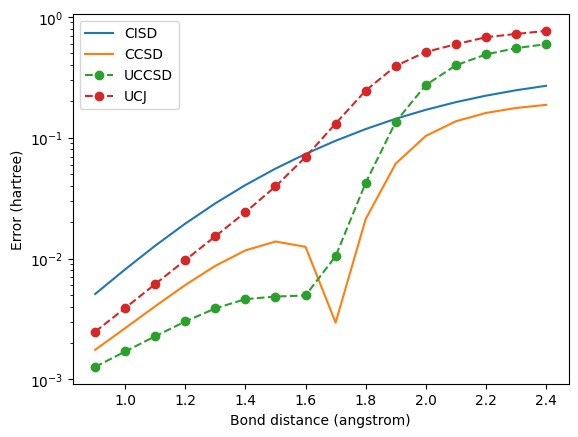

In [2]:
uccsd_errors = []
ucj_errors = []
for mol_data in mol_datas:
    # Get molecular Hamiltonian as SciPy LinearOperator
    linop = ffsim.linear_operator(mol_data.hamiltonian, norb=norb, nelec=nelec)
    # Initialize reference state as Hartree-Fock state
    reference_state = ffsim.hartree_fock_state(norb, nelec)
    # Compute UCCSD energy initialized with CCSD t-amplitudes
    uccsd_op = ffsim.UCCSDOpRestrictedReal(t1=mol_data.ccsd_t1, t2=mol_data.ccsd_t2)
    final_state = ffsim.apply_unitary(reference_state, uccsd_op, norb=norb, nelec=nelec)
    uccsd_energy = np.vdot(final_state, linop @ final_state).real
    uccsd_errors.append(uccsd_energy - mol_data.fci_energy)
    # Compute UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2, t1=mol_data.ccsd_t1
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_errors.append(ucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
ax.plot(
    bond_distance_range,
    [mol_data.cisd_energy - mol_data.fci_energy for mol_data in mol_datas],
    "-",
    label="CISD",
)
ax.plot(
    bond_distance_range,
    # Take absolute value because CCSD energy is not variational
    [abs(mol_data.ccsd_energy - mol_data.fci_energy) for mol_data in mol_datas],
    "-",
    label="CCSD",
)
ax.plot(bond_distance_range, uccsd_errors, "o--", label="UCCSD")
ax.plot(bond_distance_range, ucj_errors, "o--", label="UCJ")
ax.set_yscale("log")
ax.set_xlabel("Bond distance (angstrom)")
ax.set_ylabel("Error (hartree)")
ax.legend()

Near the equilibrium bond length, UCCSD and UCJ approximate CCSD fairly well when initialized from the $t$-amplitudes. UCCSD even attains lower errors than CCSD, with UCJ achieving somewhat higher errors. However, at stretched bond lengths, where CCSD gives unphysical energy values, both UCCSD and UCJ give large errors.

Now, we study the effect of truncating the UCJ ansatz, in both senses of limiting the number of ansatz repetitions, and dropping interactions for the LUCJ ansatz. We'll use the LUCJ variant that restricts interactions to those available on a square lattice. For both UCJ and LUCJ, we'll plot the energy error for a range of ansatz repetitions.

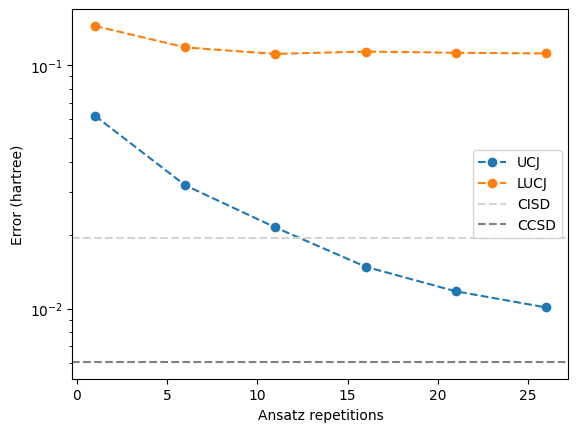

In [3]:
# Pick a specific bond length
bond_distance = 1.2
mol_data = mol_datas[bond_distance_range.searchsorted(bond_distance)]

# Get molecular Hamiltonian as SciPy LinearOperator
linop = ffsim.linear_operator(mol_data.hamiltonian, norb=norb, nelec=nelec)
# Initialize reference state as Hartree-Fock state
reference_state = ffsim.hartree_fock_state(norb, nelec)

# For LUCJ, use interactions implementable on a square lattice
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]

n_reps_range = range(1, ucj_op.n_reps + 1, 5)
ucj_errors_n_reps = []
lucj_errors_n_reps = []
for n_reps in n_reps_range:
    # Compute UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2, t1=mol_data.ccsd_t1, n_reps=n_reps
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_errors_n_reps.append(ucj_energy - mol_data.fci_energy)
    # Compute LUCJ energy initialized with CCSD t-amplitudes
    lucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
    )
    final_state = ffsim.apply_unitary(reference_state, lucj_op, norb=norb, nelec=nelec)
    lucj_energy = np.vdot(final_state, linop @ final_state).real
    lucj_errors_n_reps.append(lucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
ax.plot(n_reps_range, ucj_errors_n_reps, "o--", label="UCJ")
ax.plot(n_reps_range, lucj_errors_n_reps, "o--", label="LUCJ")
ax.axhline(
    mol_data.cisd_energy - mol_data.fci_energy,
    linestyle="--",
    color="lightgray",
    label="CISD",
)
ax.axhline(
    mol_data.ccsd_energy - mol_data.fci_energy,
    linestyle="--",
    color="gray",
    label="CCSD",
)
ax.set_yscale("log")
ax.set_xlabel("Ansatz repetitions")
ax.set_ylabel("Error (hartree)")
ax.legend()

For UCJ, the error appears to increase gradually as the number of repetitions is reduced. However, for LUCJ, the error immediately becomes large, even with close to the full number of repetitions. Evidently, the interactions omitted in the LUCJ ansatz are crucial for maintaining the approximation to CCSD.

In the next code cell, we enable the compressed double factorization by setting `optimize=True` in the `from_t_amplitudes` method.

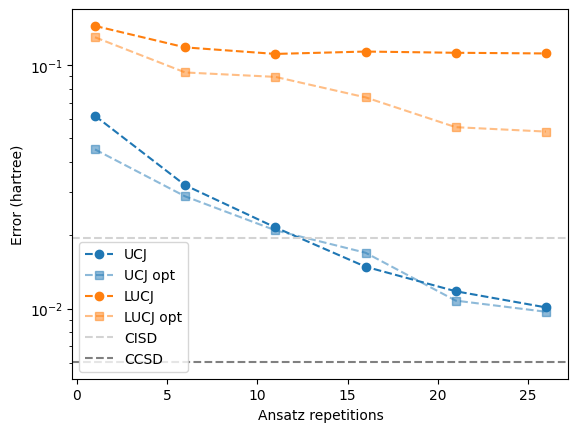

In [4]:
ucj_opt_errors_n_reps = []
lucj_opt_errors_n_reps = []
for n_reps in n_reps_range:
    # Compute "compressed" UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        optimize=True,
        options=dict(maxiter=50),
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_opt_errors_n_reps.append(ucj_energy - mol_data.fci_energy)
    # Compute "compressed" LUCJ energy initialized with CCSD t-amplitudes
    lucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
        optimize=True,
        options=dict(maxiter=50),
    )
    final_state = ffsim.apply_unitary(reference_state, lucj_op, norb=norb, nelec=nelec)
    lucj_energy = np.vdot(final_state, linop @ final_state).real
    lucj_opt_errors_n_reps.append(lucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
(line,) = ax.plot(n_reps_range, ucj_errors_n_reps, "o--", label="UCJ")
ax.plot(
    n_reps_range,
    ucj_opt_errors_n_reps,
    "s--",
    alpha=0.5,
    color=line.get_color(),
    label="UCJ opt",
)
(line,) = ax.plot(n_reps_range, lucj_errors_n_reps, "o--", label="LUCJ")
(line,) = ax.plot(
    n_reps_range,
    lucj_opt_errors_n_reps,
    "s--",
    alpha=0.5,
    color=line.get_color(),
    label="LUCJ opt",
)
ax.axhline(
    mol_data.cisd_energy - mol_data.fci_energy,
    linestyle="--",
    color="lightgray",
    label="CISD",
)
ax.axhline(
    mol_data.ccsd_energy - mol_data.fci_energy,
    linestyle="--",
    color="gray",
    label="CCSD",
)
ax.set_yscale("log")
ax.set_xlabel("Ansatz repetitions")
ax.set_ylabel("Error (hartree)")
ax.legend()

With the default settings, the compressed double factorization does not always lower the energy of the state. The reason is that although we now have a better approximation of the UCCSD generator $T_2 - T_2^\dagger = i\sum_{k=1}^L \mathcal{U}_k \mathcal{J}_k \mathcal{U}_k^\dagger,$ the Trotter error of the UCJ ansatz can increase if the norms of the individual terms in the sum become large.

The increased energy due to Trotter error may be undesirable for certain quantum algorithms, such as the [variational quantum eigensolver (VQE)](https://en.wikipedia.org/wiki/Variational_quantum_eigensolver), but it may not matter for other algorithms. For [quantum selected configuration interaction (QSCI)](https://arxiv.org/abs/2302.11320) and its extension [sample-based quantum diagonalization (SQD)](https://github.com/Qiskit/qiskit-addon-sqd), the wave function is prepared and sampled repeatedly to generate configurations on which to project and diagonalize the Hamiltonian. In these cases, the increased norms of the individual terms may actually help the algorithm by causing the wave function coefficients to spread out among a larger number of configurations, producing a more diverse set of samples.

If the increased energy due to Trotter error is undesirable, we can mitigate this issue by adding a term to the least-squares objective function that regularizes the norm of the diagonal Coulomb matrices. The objective function with the regularization term is
$$
\frac12 \sum_{ijab} \lvert \bar{t}_{ijab} - t_{ijab} \rvert ^2 +
\lambda \left( \sum_{k} \| \bar{Z}^{(k)} \|_\text{F}^2 - \sum_{k} \| Z^{(k)} \|_\text{F}^2 \right),
$$
where $\|\cdot\|_\text{F}$ denotes the Frobenius matrix norm, and $\lambda$ is a parameter that determines how strongly to weight the regularization term.

The following code cell enables this regularization by passing a value for $\lambda$ as the `regularization` argument of `from_t_amplitudes`.

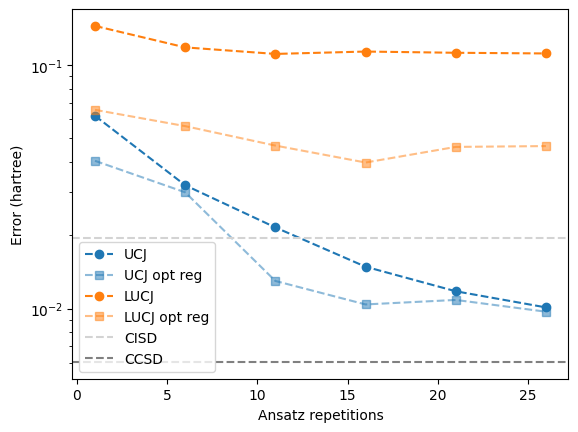

In [5]:
ucj_opt_reg_errors_n_reps = []
lucj_opt_reg_errors_n_reps = []
for n_reps in n_reps_range:
    # Compute "compressed" UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        optimize=True,
        options=dict(maxiter=50),
        regularization=1e-2,
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_opt_reg_errors_n_reps.append(ucj_energy - mol_data.fci_energy)
    # Compute "compressed" LUCJ energy initialized with CCSD t-amplitudes
    lucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
        optimize=True,
        options=dict(maxiter=50),
        regularization=1e-2,
    )
    final_state = ffsim.apply_unitary(reference_state, lucj_op, norb=norb, nelec=nelec)
    lucj_energy = np.vdot(final_state, linop @ final_state).real
    lucj_opt_reg_errors_n_reps.append(lucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
(line,) = ax.plot(n_reps_range, ucj_errors_n_reps, "o--", label="UCJ")
ax.plot(
    n_reps_range,
    ucj_opt_reg_errors_n_reps,
    "s--",
    alpha=0.5,
    color=line.get_color(),
    label="UCJ opt reg",
)
(line,) = ax.plot(n_reps_range, lucj_errors_n_reps, "o--", label="LUCJ")
(line,) = ax.plot(
    n_reps_range,
    lucj_opt_reg_errors_n_reps,
    "s--",
    alpha=0.5,
    color=line.get_color(),
    label="LUCJ opt reg",
)
ax.axhline(
    mol_data.cisd_energy - mol_data.fci_energy,
    linestyle="--",
    color="lightgray",
    label="CISD",
)
ax.axhline(
    mol_data.ccsd_energy - mol_data.fci_energy,
    linestyle="--",
    color="gray",
    label="CCSD",
)
ax.set_yscale("log")
ax.set_xlabel("Ansatz repetitions")
ax.set_ylabel("Error (hartree)")
ax.legend()

With regularization, the compressed double factorization does consistently lower the energy compared to the uncompressed double factorization.